[ pytorch IRIS 모델 ]

- 데이터셋 : iris.csv
- 학습방법 : 지도학습 + 분류 (이진분류)

< 모듈 및 파일 로딩 > <hr>

In [41]:
# [1-1] 모듈 로딩
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim      # 최적화 모듈 

from sklearn.model_selection import train_test_split

In [42]:
# [1-2] 파일로딩
data_file = 'iris.csv'

iris_df = pd.read_csv(data_file, skipfooter=50, engine='python')

In [43]:
# [1-3] 데이터 확인
iris_df.variety.unique()

array(['Setosa', 'Versicolor'], dtype=object)

In [44]:
# [1-4] 범주형 데이터 수치화
pd.set_option('future.no_silent_downcasting', True)
iris_df.variety = iris_df.variety.replace({'Setosa':0,'Versicolor':1})

iris_df.variety = iris_df.variety.astype('int64')

iris_df.dtypes

sepal.length    float64
sepal.width     float64
petal.length    float64
petal.width     float64
variety           int64
dtype: object

< 데이터셋 준비 > <hr>

In [45]:
# [2-1] 피쳐 타겟 분리
featureDF = iris_df[iris_df.columns[:-1]]  
TargetSR = iris_df[iris_df.columns[-1]]

print(TargetSR)

0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: variety, Length: 100, dtype: int64


In [46]:
# [2-2] train test 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    TargetSR,
                                                    test_size=0.2,
                                                    stratify=TargetSR,
                                                    random_state=42)

< 모델 설계 및 클래스 구현 > <hr>

In [47]:
# [3-1] 모델 클래스 설계 
## - 클래스 이 름 : IrisModel
## - 부 모 클래스 : nn.Module
## - 데 이  터 셋 : 피쳐 4 , 타겟 1 , 타겟 범주형
## - 학습    방법 : 지도학습 - 분류(이진)
## - 구현알고리즘 : 인공신경망계열 DNN 
## -------------------------------------------------
##             입력       출력/퍼셉트론수    활성화함수
## - 입력층      3(피쳐)   20               ReLU
## - 은닉층      20       10                ReLU
## - 은닉층      10        5                ReLU
## - 출력층       5        1(타겟)          Sigmoid
## 피쳐와 타겟을 제외하고 나머지는 사용자 지정 : 단, 초반에 퍼셉트론 수가 많은 것은 GOOD

In [48]:
# 클래스 생성
class IrisModel(nn.Module):
    
    def __init__(self, in_in, in_out, h1_out, h2_out, out_out):
        super().__init__()
        pass
        
        self.input_layer = nn.Linear(in_in, in_out)
        self.hidden_layer1 = nn.Linear(in_out, h1_out)
        self.hidden_layer2 = nn.Linear(h1_out, h2_out)
        self.output_layer = nn.Linear(h2_out, out_out)
        
    
    # 순방향 학습 진행 메서드 : forward로 무조건 고정!!
    # forward : 필수 오버라이딩 메서드 
    # 매개변수 data : 학습용 데이터 전달
    
    # 입력층 학습 
    def forward(self,data):     
        output = self.input_layer(data)
        output = F.relu(output)
        
        output = self.hidden_layer1(output)
        output = F.relu(output)
        
        output = self.hidden_layer2(output)
        output = F.relu(output)
        
        output = self.output_layer(output)
        output = F.sigmoid(output)
    
        return output
        

In [49]:
# [3-2] 모델 구조 확인
model = IrisModel(4,20,10,5,1)

print(model)

IrisModel(
  (input_layer): Linear(in_features=4, out_features=20, bias=True)
  (hidden_layer1): Linear(in_features=20, out_features=10, bias=True)
  (hidden_layer2): Linear(in_features=10, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [64]:
print(torch.FloatTensor([[2,3,4,5]]).shape)   # 1행 4열
print(torch.FloatTensor([[2,3,4,5]]).ndim)

model(torch.FloatTensor([[2,3,4,5]]))

torch.Size([1, 4])
2


tensor([[0.4646]], grad_fn=<SigmoidBackward0>)

< 학습 준비 > <hr>

In [51]:
# [4-1] 학습 관련 설정들
EPOCHS = 10              # 학습용 DS를 처음부터 끝까지 10번 학습
BATCH_SIZE = 40          # DS를 학습량 만큼 나눈 사이즈
ITERATION = int(x_train.shape[0]/BATCH_SIZE)             # 학습용 DS가 분리된 수 => 1 에포크에 W,b 업데이트 횟수 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정  

print(f'EPOCHS : {EPOCHS}')
print(f'BATCH_SIZE : {BATCH_SIZE}')
print(f'ITERATION : {ITERATION}')
print(f'DEVICE : {DEVICE}')

EPOCHS : 10
BATCH_SIZE : 40
ITERATION : 2
DEVICE : cpu


In [ ]:
# [4-2] 학습 관련 인스턴스들 
MODEL = IrisModel(4,20,10,5,1)               # 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters())   # 최적화, 즉 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.BCELoss()                       # 이진 분류 손실계산 인스턴스

In [53]:
# [4-3] 학습 함수
def training():
    
    # 학습 모드 설정
    model.train()
    
    # 에포크 : DS 처음부터 ~ 끝까지 학습
    for epoch in range(EPOCHS):
        
        E_LOSS = 0
        for i in range(ITERATION):
            start = i * BATCH_SIZE
            end = start + BATCH_SIZE
            
            # ndarray => tensor 변환
            x = torch.FloatTensor(x_train.values[start:end])
            y = torch.FloatTensor(y_train.values[start:end])
            
            # 가중치 / 기울기 0 초기화
            OPTIMIZER.zero_grad()
            
            # 학습 진행
            pre_y = MODEL(x)
            
            # 손실 계산
            loss = LOSS_FN(pre_y, y.reshape(-1,1))
            
            # 역전파 진행
            loss.backward()
            
            # 가중치 / 절편 업데이트
            OPTIMIZER.step()
            
            E_LOSS += loss.item()
            
        print(f'[EPOCH - {epoch}  LOSS - {E_LOSS/ITERATION}]')
    
    return loss

In [54]:
training()

[EPOCH - 0  LOSS - 0.7122037708759308]
[EPOCH - 1  LOSS - 0.7108735144138336]
[EPOCH - 2  LOSS - 0.7095806300640106]
[EPOCH - 3  LOSS - 0.7086102664470673]
[EPOCH - 4  LOSS - 0.7082152366638184]
[EPOCH - 5  LOSS - 0.7079032063484192]
[EPOCH - 6  LOSS - 0.7075955271720886]
[EPOCH - 7  LOSS - 0.707293838262558]
[EPOCH - 8  LOSS - 0.7069993317127228]
[EPOCH - 9  LOSS - 0.7067127227783203]


tensor(0.7147, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
# [4-4] 검증 함수
# - 검증용 데이터셋으로 모델 검증
# - 학습 지속여부 결정 기준이 됨

def evaluate():
    # 에포크 단위로 검증 -> 검증 모드
    MODEL.eval()
    
    # W,b 업데이트 해제
    with torch.no_grad():
        # 검증용 데이터셋 -> 텐서화
        # ndarray -> tensor 변환
        x = torch.FloatTensor(x_test.values)
        y = torch.FloatTensor(y_test.values)
        
        # 검증 진행
        pre_y = MODEL(x)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1,1))     # [[0.4646]], y는 2차원
        
    return loss.item()

In [56]:
evaluate()

0.706631600856781

In [ ]:
# [4-5] 학습 함수2
def training():
    
    # 학습 모드 설정
    model.train()
        
    E_LOSS = 0
    for i in range(ITERATION):
        start = i * BATCH_SIZE
        end = start + BATCH_SIZE
        
        # ndarray(values) => tensor 변환
        x = torch.FloatTensor(x_train.values[start:end])
        y = torch.FloatTensor(y_train.values[start:end])
        
        # 가중치 / 기울기 0 초기화
        OPTIMIZER.zero_grad()
        
        # 학습 진행
        pre_y = MODEL(x)
        
        # 손실 계산
        loss = LOSS_FN(pre_y, y.reshape(-1,1))
        
        # 역전파 진행
        loss.backward()
        
        # 가중치 / 절편 업데이트
        OPTIMIZER.step()
        
        E_LOSS += loss.item()
    
    return loss

In [58]:
# [4-6] 학습 / 검증 동시 진행 함수

# 에포크 : DS 처음부터 ~ 끝까지 학습
LOSS_HIST = {'Train' : [], 'Valid' : []}

# 에포크 단위 학습/검증 진행
for epoch in range(EPOCHS):
    trainLoss = training()
    validLoss = evaluate()
    
    LOSS_HIST['Train'].append(trainLoss)
    LOSS_HIST['Valid'].append(validLoss)
    
    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]------------------------')
    print(f'TRAIN LOSS {trainLoss:.5f}')
    print(f'VALID LOSS {validLoss:.5f}')


EPOCH[1/10]------------------------
TRAIN LOSS 0.71434
VALID LOSS 0.70635

EPOCH[2/10]------------------------
TRAIN LOSS 0.71403
VALID LOSS 0.70608

EPOCH[3/10]------------------------
TRAIN LOSS 0.71373
VALID LOSS 0.70582

EPOCH[4/10]------------------------
TRAIN LOSS 0.71344
VALID LOSS 0.70556

EPOCH[5/10]------------------------
TRAIN LOSS 0.71315
VALID LOSS 0.70532

EPOCH[6/10]------------------------
TRAIN LOSS 0.71287
VALID LOSS 0.70508

EPOCH[7/10]------------------------
TRAIN LOSS 0.71260
VALID LOSS 0.70485

EPOCH[8/10]------------------------
TRAIN LOSS 0.71234
VALID LOSS 0.70463

EPOCH[9/10]------------------------
TRAIN LOSS 0.71209
VALID LOSS 0.70442

EPOCH[10/10]------------------------
TRAIN LOSS 0.71184
VALID LOSS 0.70422


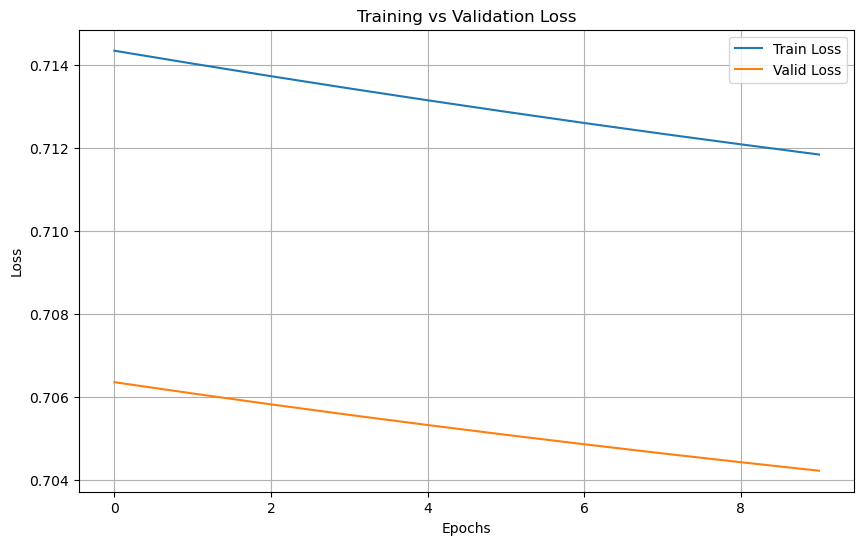

In [61]:
# [4-7] 시각화 
import matplotlib.pyplot as plt

train_loss = torch.tensor(LOSS_HIST['Train']).detach().numpy()
valid_loss = torch.tensor(LOSS_HIST['Valid']).detach().numpy()


# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')

# 그래프 꾸미기
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()
